In [3]:
# Installing the required packages
!pip install librosa soundfile matplotlib pandas numpy

In [4]:
# Connecting with google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/cadenza_lyric_intelligibility_challenge/data/cadenza_clip1_data.train.v1.0/cadenza_data"

Mounted at /content/drive


In [5]:
# Imports of all libraries
import os, json
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [6]:
# Defining path for meta data exploration
train_meta_path = os.path.join(DATA_ROOT, "metadata", "train_metadata.json")

with open(train_meta_path, "r") as f:
    train_data = json.load(f)

df = pd.DataFrame(train_data)
df.head() # Examining head to see what the data looks like

,signal,prompt,response,n_words,words_correct,correctness,hearing_loss
0,c221f2084c780e8f212f4697,cos you better hold on,#,5,0,0.000000,Moderate
1,63de05fbfcab2d7748b83cb3,And then lower it down again,I don't know where it's all the same,6,1,0.166667,Mild
2,cf74c013a02d82d04254a910,"the blind sleep, and the deaf and dumb sleep",The blind sleep and the deaf under sleep,9,7,0.777778,No Loss
3,56f3fb4847d2c90f38e8e983,a street a couple of cars and maybe some trees,#,10,0,0.000000,Moderate
4,b2486a8e181f84acd2db4d61,in my mind I can see is fine,#,8,0,0.000000,Moderate


In [7]:
# Displaying more information
print("Total samples:", len(df))
print("\nHearing loss distribution:")
print(df["hearing_loss"].value_counts())

df.describe().loc[["mean", "std", "min", "max"]]

Total samples: 8802

Hearing loss distribution:
hearing_loss
Mild        2935
Moderate    2934
No Loss     2933
Name: count, dtype: int64


,n_words,words_correct,correctness
mean,7.316519,3.180754,0.430278
std,1.672484,2.797515,0.357664
min,5.000000,0.000000,0.000000
max,13.000000,12.000000,1.000000


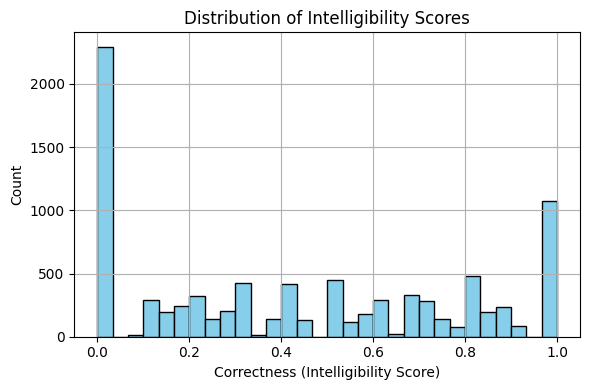

In [8]:
# Mapping correctness score with their respective counts (how frequent were intelligibilty values)
plt.figure(figsize=(6,4))
df["correctness"].hist(bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Correctness (Intelligibility Score)")
plt.ylabel("Count")
plt.title("Distribution of Intelligibility Scores")
plt.tight_layout()

plot_dir = os.path.join(DATA_ROOT, "plots")
os.makedirs(plot_dir, exist_ok=True)

plt.savefig(os.path.join(plot_dir, "correctness_hist.pdf"))
plt.show()

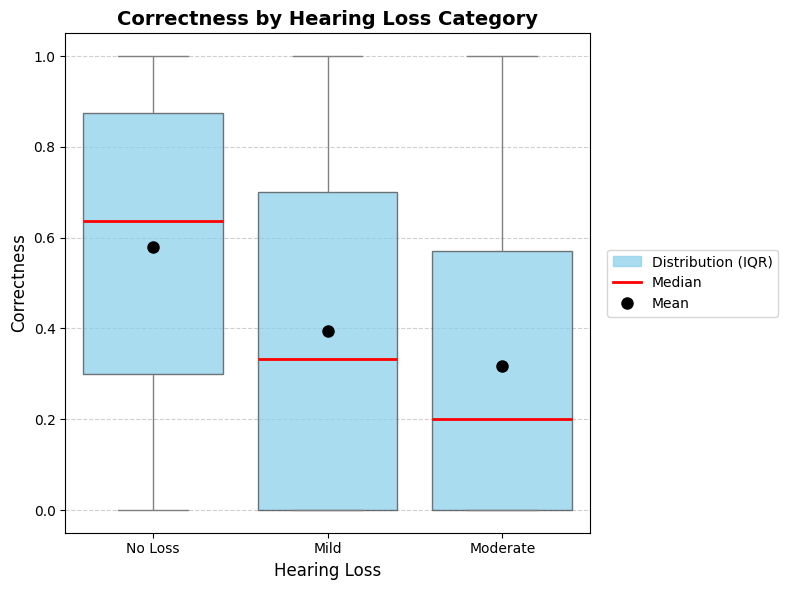

In [10]:
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Now comparing intelligibility scores in each hearing category
order = ["No Loss", "Mild", "Moderate"] # Ensuring hearing loss order
df["hearing_loss"] = pd.Categorical(df["hearing_loss"], categories=order, ordered=True)

plt.figure(figsize=(8,6))

sns.boxplot(
    data=df,
    x="hearing_loss",
    y="correctness",
    order=order,
    showmeans=True,
    meanprops={
        "marker":"o",
        "markerfacecolor":"black",
        "markeredgecolor":"black",
        "markersize":"8"
    },
    boxprops={"facecolor":"skyblue", "alpha":0.7},
    medianprops={"color":"red", "linewidth":2},
    whiskerprops={"color":"gray"},
    capprops={"color":"gray"}
)

plt.title("Correctness by Hearing Loss Category", fontsize=14, fontweight="bold")
plt.xlabel("Hearing Loss", fontsize=12)
plt.ylabel("Correctness", fontsize=12)
plt.ylim(-0.05, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.6)

median_line = mlines.Line2D([], [], color='red', linewidth=2, label='Median')
mean_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Mean')
box_patch = mpatches.Patch(color='skyblue', alpha=0.7, label='Distribution (IQR)')

plt.legend(
    handles=[box_patch, median_line, mean_dot],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=10,
    frameon=True
)

plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "correctness_by_loss.pdf"))
plt.show()

Files missing: 0
Missing files: 0 / 8802 (0.00%)
Total files processed: 8802
Average duration (sec): 4.484845319632056
Min duration: 1.1345351473922902
Max duration: 22.957278911564625
Average sample rate: 44100.0
Unique sample rates: [44100]
Correlation (duration vs. sample rate): nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


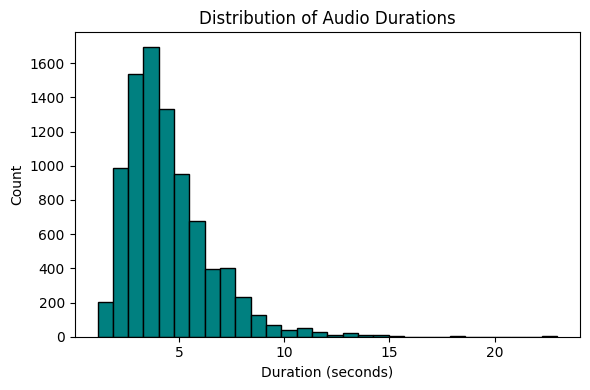

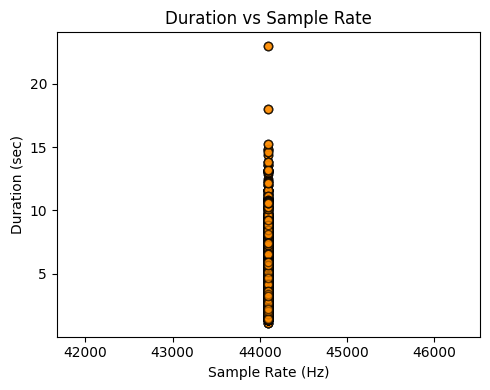

In [11]:
# Audio duration, sample rate and comparison charts
signal_dir = os.path.join(DATA_ROOT, "train", "signals")

durations = []
sample_rates = []
missing = 0

for fname in df["signal"]:
    fpath = os.path.join(signal_dir, f"{fname}.flac")
    try:
        y, sr = librosa.load(fpath, sr=None)
        durations.append(len(y) / sr)
        sample_rates.append(sr)
    except Exception as e:
        missing += 1

print("Files missing:", missing)
loss_pct = 100 * missing / len(df)
print(f"Missing files: {missing} / {len(df)} ({loss_pct:.2f}%)")
print("Total files processed:", len(durations))
print("Average duration (sec):", np.mean(durations))
print("Min duration:", np.min(durations))
print("Max duration:", np.max(durations))
print("Average sample rate:", np.mean(sample_rates))
print("Unique sample rates:", np.unique(sample_rates))

corr = np.corrcoef(durations, sample_rates)[0, 1]
print("Correlation (duration vs. sample rate):", round(corr, 4))

plt.figure(figsize=(6,4))
plt.hist(durations, bins=30, color='teal', edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio Durations")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "duration_hist.pdf"))
plt.show()

plt.figure(figsize=(5,4))
plt.scatter(sample_rates, durations, alpha=0.6, color='darkorange', edgecolors='black')
plt.xlabel("Sample Rate (Hz)")
plt.ylabel("Duration (sec)")
plt.title("Duration vs Sample Rate")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "duration_vs_sr.pdf"))
plt.show()

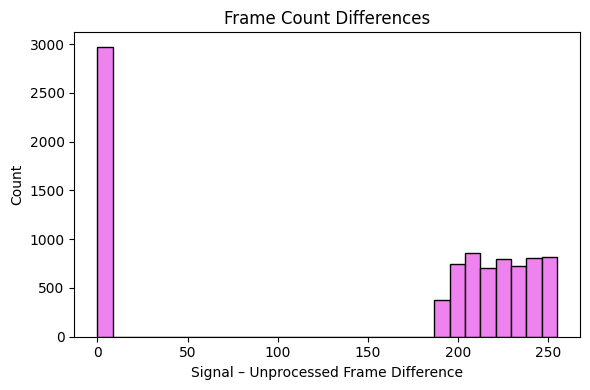

In [12]:
# Computing frame length difference between signals and unprocessed
proc_dir = os.path.join(DATA_ROOT, "train", "signals")
unproc_dir = os.path.join(DATA_ROOT, "train", "unprocessed")

frame_diffs = []

for fname in df["signal"]:
    sig_path = os.path.join(proc_dir, f"{fname}.flac")
    unproc_path = os.path.join(unproc_dir, f"{fname}_unproc.flac")
    try:
        y_sig, _ = librosa.load(sig_path, sr=None)
        y_un, _ = librosa.load(unproc_path, sr=None)
        frame_diffs.append(len(y_sig) - len(y_un))
    except:
        pass

plt.figure(figsize=(6,4))
plt.hist(frame_diffs, bins=30, color='violet', edgecolor='black')
plt.xlabel("Signal – Unprocessed Frame Difference")
plt.ylabel("Count")
plt.title("Frame Count Differences")
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "frame_diff_hist.pdf"))
plt.show()

Example: bb6a04dbc7b5de07a7b4c31e, Sample Rate: 44100, Duration: 4.22 sec


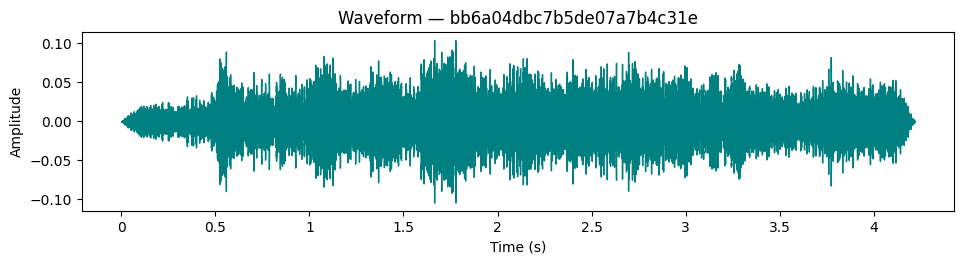

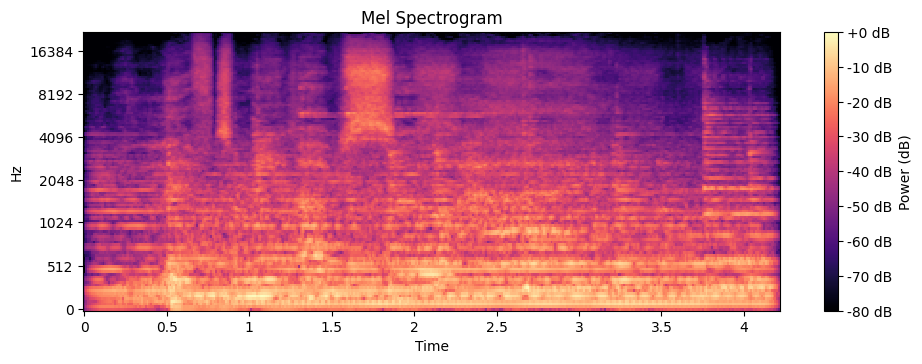

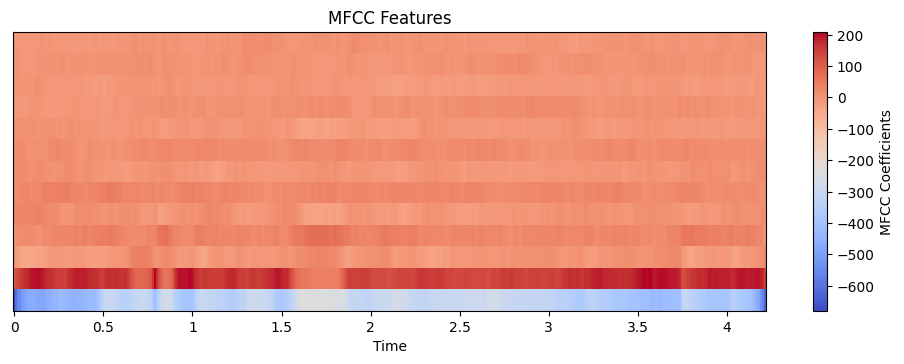

In [13]:
# Selecting random audio file to examine
example = df.sample(1).iloc[0]
sig_path = os.path.join(signal_dir, f"{example['signal']}.flac")

y, sr = librosa.load(sig_path, sr=None)
print(f"Example: {example['signal']}, Sample Rate: {sr}, Duration: {len(y)/sr:.2f} sec")

# This displays the waveform (to see spikes, silence and sound regions)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr, color='teal')
plt.title(f"Waveform — {example['signal']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(plot_dir, "waveform_example.pdf"))
plt.show()

# Mel Spectogram to help identify energy distribution, artifacts, noise and clarity
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(img, format="%+2.0f dB", label="Power (dB)")
plt.title("Mel Spectrogram")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(plot_dir, "mel_spec_example.pdf"))
plt.show()

# Mel-Frequency Cepstral Coefficients (MFCC) which turn an audio signal into numbers that describe how it sounds
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
img2 = librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='coolwarm')
plt.colorbar(img2, label="MFCC Coefficients")
plt.title("MFCC Features")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(plot_dir, "mfcc_example.pdf"))
plt.show()


                n_words  words_correct  correctness
n_words        1.000000       0.312263     0.054539
words_correct  0.312263       1.000000     0.941761
correctness    0.054539       0.941761     1.000000


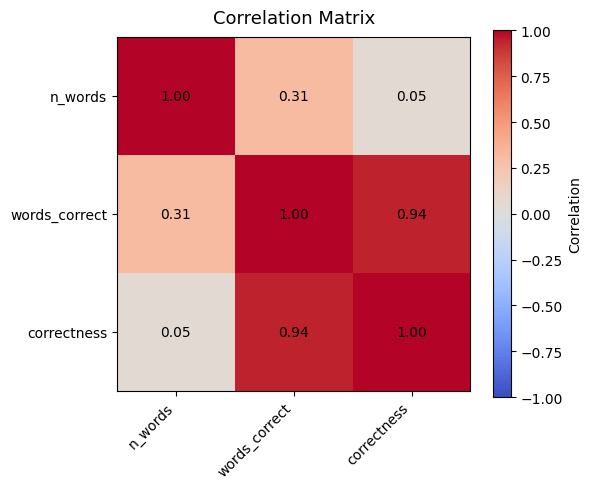

In [14]:
# Check correlation among numeric fields
corr = df[["n_words", "words_correct", "correctness"]].corr()
print(corr)

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=10)
plt.title("Correlation Matrix", fontsize=13, pad=10)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "correlation_matrix.pdf"))
plt.show()